In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

from utils import simulate_gbm

In [2]:
def mean_diff(S0, mu, sigma, T, N, n_paths, leverage):
    return simulate_gbm(S0, mu, sigma, T, int(N), n_paths, leverage).mean()

In [3]:
def std_diff(S0, mu, sigma, T, N, n_paths, leverage):
    return simulate_gbm(S0, mu, sigma, T, int(N), n_paths, leverage).std()

In [ ]:
def lev_sigma_std(
    mu=0,
    sigmas=np.linspace(0.01, 0.4, 100),
    T=5,
    freq=1,
    n_paths=10000,
    factors=np.linspace(1.01, 3, 100),
):
    factor, sigma = np.meshgrid(factors, sigmas, indexing="ij")

    std = np.vectorize(std_diff)(1, mu, sigma, T, T * freq, n_paths, factor)

    return pd.DataFrame(
        {"factor": factor.ravel(), "sigma": sigma.ravel(), "std": std.ravel()}
    )

In [8]:
df = lev_sigma_std()

/home/roberto/Projects/Quant finance/Leveraged ETFs/utils.py:21: RuntimeWarning: invalid value encountered in log
  np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)


In [ ]:
def plot_heat_lev_sigma_std(df):
    plt.figure(figsize=(8, 6))

    # We use a scatter plot where the 'hue' is the function output
    sns.scatterplot(
        data=df, x="factor", y="sigma", hue="std", palette="coolwarm", edgecolor=None
    )

    plt.title("standard deviation of percentage difference lETF - underlying")
    plt.show()

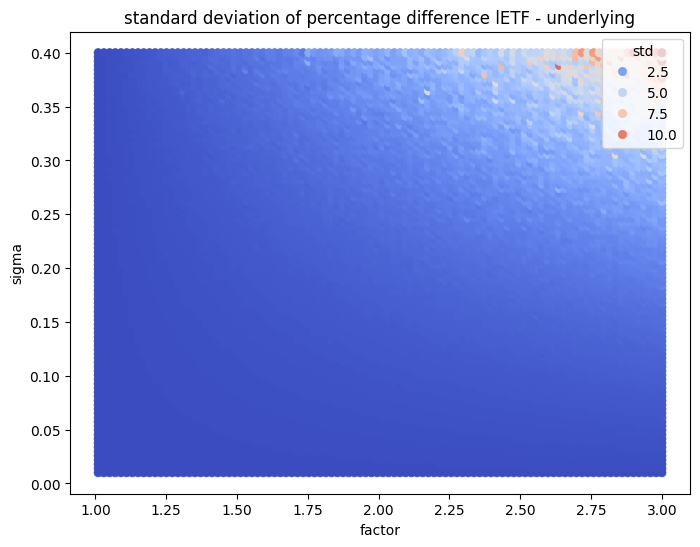

In [11]:
plot_heat_lev_sigma_std(df)

In [ ]:
def plot_heat_lev_sigma_mean(
    mu=0,
    sigmas=np.linspace(0.01, 0.4, 100),
    T=5,
    freq=1,
    n_paths=1000,
    factors=np.linspace(1.01, 3, 100),
):
    factor, sigma = np.meshgrid(factors, sigmas)

    diff = np.vectorize(mean_diff)(1, mu, sigma, T, T * freq, n_paths, factor)

    plt.figure(figsize=(4, 3))
    plt.contourf(factor, sigma, diff, cmap="coolwarm")
    plt.title("mean of percentage difference lETF - underlying")
    plt.xlabel("leverage factor")
    plt.ylabel("sigma")
    plt.colorbar()

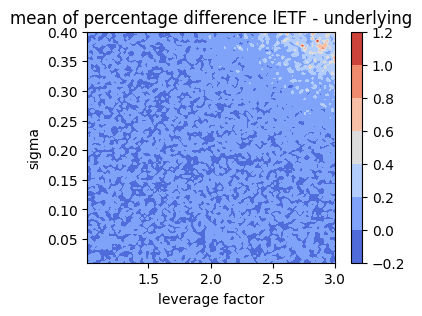

In [7]:
plot_heat_lev_sigma_mean()

In [26]:
def plot_surface_lev_sigma_std(df):
    # 1. Reconstruct the 1D axes from the dataframe
    # We sort them to ensure the grid aligns correctly
    factors_1d = np.sort(df["factor"].unique())
    sigmas_1d = np.sort(df["sigma"].unique())

    # 2. Reshape the 'z' data back into a 2D grid
    # index=y (rows), columns=x (cols)
    z_matrix = df.pivot(index="sigma", columns="factor", values="std").values

    # 3. Create the interactive surface
    fig = go.Figure(
        data=[
            go.Surface(
                x=factors_1d,  # The 1D array of leverage factors
                y=sigmas_1d,  # The 1D array of sigmas
                z=z_matrix,  # The 2D grid of results
                colorscale="RdBu",
                colorbar=dict(title="log std diff"),
            )
        ]
    )

    fig.update_layout(
        title="Log std of percentage difference lETF - underlying",
        scene=dict(
            xaxis_title="leverage factor",
            yaxis_title="sigma",
            zaxis_title="log std diff",
        ),
        width=750,
        height=650,
    )

    fig.show()

In [16]:
plot_surface_lev_sigma_std(df)

In [ ]:
df.to_csv("output/lev_sigma_std.csv")

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# 1. Prepare your features (X) and target (y)
# df has columns ['factor', 'sigma', 'std']
X = df[["factor", "sigma"]]
z = df["std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [("poly", PolynomialFeatures(degree=2)), ("linear", LinearRegression())]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["std_fitted"] = model.predict(X)

In [23]:
df

,factor,sigma,std,std_fitted
0,1.01,0.010000,0.000223,1.040659
1,1.01,0.013939,0.000312,0.996073
2,1.01,0.017879,0.000395,0.952230
3,1.01,0.021818,0.000490,0.909131
4,1.01,0.025758,0.000574,0.866775
...,...,...,...,...
9995,3.00,0.384242,8.299343,5.949328
9996,3.00,0.388182,7.208645,6.049762
9997,3.00,0.392121,11.668013,6.150940
9998,3.00,0.396061,6.279569,6.252862


In [ ]:
def plot_pred_lev_sigma_std(df):
    # 1. Reconstruct the 1D axes from the dataframe
    # We sort them to ensure the grid aligns correctly
    factors_1d = np.sort(df["factor"].unique())
    sigmas_1d = np.sort(df["sigma"].unique())

    # 2. Reshape the 'z' data back into a 2D grid
    # index=y (rows), columns=x (cols)
    z_matrix = df.pivot(index="sigma", columns="factor", values="std").values
    pred_matrix = df.pivot(index="sigma", columns="factor", values="std_fitted").values

    # 3. Create the interactive surface
    fig = go.Figure(
        data=[
            go.Surface(
                x=factors_1d,  # The 1D array of leverage factors
                y=sigmas_1d,  # The 1D array of sigmas
                z=z_matrix,  # The 2D grid of results
                colorscale="RdBu",
                colorbar=dict(title="log std diff"),
            ),
            go.Surface(
                x=factors_1d,  # The 1D array of leverage factors
                y=sigmas_1d,  # The 1D array of sigmas
                z=pred_matrix,  # The 2D grid of predictions
                # colorscale="RdBu",
                colorbar=dict(title="log std diff"),
            ),
        ]
    )

    fig.update_layout(
        title="Log std of percentage difference lETF - underlying",
        scene=dict(
            xaxis_title="leverage factor",
            yaxis_title="sigma",
            zaxis_title="log std diff",
        ),
        width=750,
        height=650,
    )

    fig.show()

In [27]:
plot_pred_lev_sigma_std(df)

Proposed models:
- quadratic regression
- quadratic regression with weighted least squares
- quartic regression with fixing coefficients to have 0 at the boundary (doesn't address heteroskedacity): $(ax + bx^2)(cy + dy^2)$
- fit log(1 + std)

Do a 5-fold split with 5 generated dataframes, compute rmse for each model (new notebook).